In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")

import wrangle
import split_scale


In [2]:
grades = pd.read_csv('student_grades.csv')

In [3]:
grades.head()

,student_id,exam1,exam2,exam3,final_grade
0,1,100.0,90,95,96
1,2,98.0,93,96,95
2,3,85.0,83,87,87
3,4,83.0,80,86,85
4,5,93.0,90,96,97


In [4]:
grades.dtypes

student_id       int64
exam1          float64
exam2            int64
exam3           object
final_grade      int64
dtype: object

In [5]:
df = wrangle.wrangle_grades()
df.head()

,exam1,exam2,exam3,final_grade
0,100,90,95,96
1,98,93,96,95
2,85,83,87,87
3,83,80,86,85
4,93,90,96,97


In [6]:
train, test = split_scale.split_my_data(df)

In [7]:
X_train = train.drop(columns='final_grade')
y_train = train[['final_grade']]
X_test = test.drop(columns='final_grade')
y_test = test[['final_grade']]

## Select the top 1 features using Recursive Feature Elimination

In [8]:
# Initialize the Linear Regression Object 
lm = LinearRegression()

rfe = RFE(lm, 1)

# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

In [9]:
# boolean mask for each variable of whether it was selected or not. 
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = X_train.columns[mask]

# print them out here for our reference
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 1 features: exam1


## Simple model

In [10]:
predictions = pd.DataFrame({
    'actual': train.final_grade
})

In [11]:
predictions.head()

,actual
86,77
21,77
31,81
33,76
102,65


In [12]:
import sklearn.linear_model

In [13]:
# for exam 1
# X must be 2-d
X = train[['exam1']]
# y can be 1-d
y = train.final_grade

# 1. make the thing
lm = sklearn.linear_model.LinearRegression()
# 2. fit the thing
lm.fit(X, y)
# 3. use the thing
predictions['simple_lm_exam1'] = lm.predict(X)

In [14]:
predictions.head()

,actual,simple_lm_exam1
86,77,75.341560
21,77,75.341560
31,81,82.203999
33,76,77.629040
102,65,65.429150


In [15]:
lm.coef_, lm.intercept_

(array([0.76249314]), 21.96704090141759)

In [16]:
print('final_grade = {:.3f} * exam1 + {:.3f}'.format(lm.coef_[0], lm.intercept_))

final_grade = 0.762 * exam1 + 21.967


In [17]:
# for exam 2
X = train[['exam2']]
y = train.final_grade
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['simple_lm_exam2'] = lm.predict(X)

In [18]:
predictions.head()

,actual,simple_lm_exam1,simple_lm_exam2
86,77,75.341560,69.572030
21,77,75.341560,69.572030
31,81,82.203999,74.445625
33,76,77.629040,74.445625
102,65,65.429150,69.572030


In [19]:
lm.coef_, lm.intercept_

(array([0.97471891]), 6.21530132479549)

In [20]:
print('final_grade = {:.3f} * exam2 + {:.3f}'.format(lm.coef_[0], lm.intercept_))

final_grade = 0.975 * exam2 + 6.215


In [21]:
predictions.head()

,actual,simple_lm_exam1,simple_lm_exam2
86,77,75.341560,69.572030
21,77,75.341560,69.572030
31,81,82.203999,74.445625
33,76,77.629040,74.445625
102,65,65.429150,69.572030


In [22]:
MSE_exam1 = sklearn.metrics.mean_squared_error(predictions.actual, predictions.simple_lm_exam1)
MSE_exam1

3.4059329666817035

In [23]:
MSE_exam2 = sklearn.metrics.mean_squared_error(predictions.actual, predictions.simple_lm_exam2)
MSE_exam2

16.067423388644805

In [24]:
predictions['residual_1'] = predictions.actual - predictions.simple_lm_exam1
predictions['residual_2'] = predictions.actual - predictions.simple_lm_exam2
predictions.head()

,actual,simple_lm_exam1,simple_lm_exam2,residual_1,residual_2
86,77,75.341560,69.572030,1.658440,7.427970
21,77,75.341560,69.572030,1.658440,7.427970
31,81,82.203999,74.445625,-1.203999,6.554375
33,76,77.629040,74.445625,-1.629040,1.554375
102,65,65.429150,69.572030,-0.429150,-4.572030


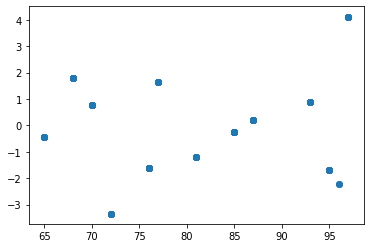

In [25]:
plt.scatter(predictions.actual, predictions.residual_1)

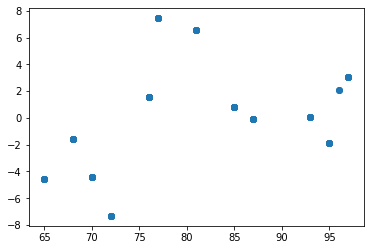

In [26]:
plt.scatter(predictions.actual, predictions.residual_2)

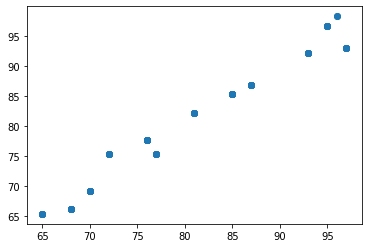

In [27]:
plt.scatter(predictions.actual, predictions.simple_lm_exam1)

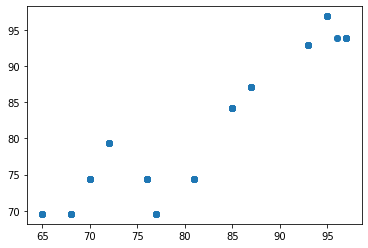

In [28]:
plt.scatter(predictions.actual, predictions.simple_lm_exam2)

### 5 .Create a model that uses exam 1 and exam 3 to predict final grade. How does this model compare to your previous ones?

In [29]:
X = train.drop(columns='final_grade')
y = train.final_grade

lm = sklearn.linear_model.LinearRegression()
k = 2

# 1. Transform our X
rfe = sklearn.feature_selection.RFE(lm, 2)
rfe.fit(X, y)
print('selected top 2 features:', X.columns[rfe.support_])
X_rfe = rfe.transform(X)

# 2. Use the transformed x in our model
lm.fit(X_rfe, y)

predictions['multiple_rfe'] = lm.predict(X_rfe)

predictions.head()

selected top 2 features: Index(['exam1', 'exam3'], dtype='object')


,actual,simple_lm_exam1,simple_lm_exam2,residual_1,residual_2,multiple_rfe
86,77,75.341560,69.572030,1.658440,7.427970,75.055828
21,77,75.341560,69.572030,1.658440,7.427970,75.055828
31,81,82.203999,74.445625,-1.203999,6.554375,82.355741
33,76,77.629040,74.445625,-1.629040,1.554375,76.103539
102,65,65.429150,69.572030,-0.429150,-4.572030,66.358968


In [30]:
X.columns[rfe.support_]

Index(['exam1', 'exam3'], dtype='object')

In [31]:
lm.coef_, lm.intercept_

(array([0.60903568, 0.25979875]), 12.159028360063573)

In [32]:
MSE_exam1_3 = sklearn.metrics.mean_squared_error(predictions.actual, predictions.multiple_rfe)
MSE_exam1_3

2.8611724029558094

### 6.Take your best preforming model and measure its performance on the test data set. How does performance differ between train and test?

In [33]:
X = test.drop(columns='final_grade')
y = test.final_grade

lm = sklearn.linear_model.LinearRegression()
k = 2

# 1. Transform our X
rfe = sklearn.feature_selection.RFE(lm, 2)
rfe.fit(X, y)
print('selected top 2 features:', X.columns[rfe.support_])
X_rfe = rfe.transform(X)

# 2. Use the transformed x in our model
lm.fit(X_rfe, y)



selected top 2 features: Index(['exam1', 'exam3'], dtype='object')


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
X.columns[rfe.support_]

Index(['exam1', 'exam3'], dtype='object')

In [35]:
lm.coef_, lm.intercept_

(array([0.34958539, 0.66518251]), -1.8681320816466496)

# Telco churn

In [36]:
df = wrangle.wrangle_telco()

In [37]:
df.head()

,customer_id,monthly_charges,tenure,total_charges
0,0013-SMEOE,109.70,71,7904.25
1,0014-BMAQU,84.65,63,5377.80
2,0016-QLJIS,90.45,65,5957.90
3,0017-DINOC,45.20,54,2460.55
4,0017-IUDMW,116.80,72,8456.75


In [38]:
train, test = split_scale.split_my_data(df)

In [39]:
train.head()

,customer_id,monthly_charges,tenure,total_charges
119,0707-HOVVN,75.50,70,5212.65
1424,8380-MQINP,20.30,55,1079.05
385,2307-FYNNL,109.05,65,7108.20
1140,6797-LNAQX,98.30,70,6859.50
1504,8879-XUAHX,116.25,71,8564.75


In [40]:
train = train[['monthly_charges','tenure','total_charges']]
test = test[['monthly_charges','tenure','total_charges']]

In [41]:
scaler, train, test = split_scale.standard_scaler(train, test)

In [42]:
train.head(3)

,monthly_charges,tenure,total_charges
119,0.419607,0.729412,0.572659
1424,-1.169158,-0.130571,-1.035331
385,1.385242,0.442751,1.310036


In [43]:
test.head(3)

,monthly_charges,tenure,total_charges
305,-1.163401,0.844077,-0.870704
452,1.450002,0.557416,1.488589
917,1.389560,0.328087,1.287299


In [44]:
predictions = pd.DataFrame({
    'actual_total_charges': train.total_charges
})

In [45]:
X = train[['tenure']]
# y can be 1-d
y = train.total_charges

# 1. make the thing
lm = sklearn.linear_model.LinearRegression()
# 2. fit the thing
lm.fit(X, y)
# 3. use the thing
predictions['tenure_lm'] = lm.predict(X)

In [46]:
lm.coef_, lm.intercept_

(array([0.63045407]), 6.679185851754575e-17)

In [47]:
predictions.head()

,actual_total_charges,tenure_lm
119,0.572659,0.459861
1424,-1.035331,-0.082319
385,1.310036,0.279134
1140,1.213291,0.459861
1504,1.876641,0.496006


In [48]:
X = train[['monthly_charges']]
# y can be 1-d
y = train.total_charges

# 1. make the thing
lm = sklearn.linear_model.LinearRegression()
# 2. fit the thing
lm.fit(X, y)
# 3. use the thing
predictions['monthly_charges_lm'] = lm.predict(X)

In [49]:
predictions.head()

,actual_total_charges,tenure_lm,monthly_charges_lm
119,0.572659,0.459861,0.396864
1424,-1.035331,-0.082319,-1.105787
385,1.310036,0.279134,1.310159
1140,1.213291,0.459861,1.017524
1504,1.876641,0.496006,1.506157


In [50]:
X = train[['tenure','monthly_charges']]
# y can be 1-d
y = train.total_charges

# 1. make the thing
lm = sklearn.linear_model.LinearRegression()
# 2. fit the thing
lm.fit(X, y)
# 3. use the thing
predictions['tenure_and_monthly_charges_lm'] = lm.predict(X)

In [51]:
predictions.head(3)

,actual_total_charges,tenure_lm,monthly_charges_lm,tenure_and_monthly_charges_lm
119,0.572659,0.459861,0.396864,0.557299
1424,-1.035331,-0.082319,-1.105787,-1.003895
385,1.310036,0.279134,1.310159,1.272574


In [52]:
predictions['baseline'] = predictions.actual_total_charges.mean()
predictions.head(3)

,actual_total_charges,tenure_lm,monthly_charges_lm,tenure_and_monthly_charges_lm,baseline
119,0.572659,0.459861,0.396864,0.557299,3.887428e-17
1424,-1.035331,-0.082319,-1.105787,-1.003895,3.887428e-17
385,1.310036,0.279134,1.310159,1.272574,3.887428e-17


In [53]:
predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual_total_charges, col))

actual_total_charges             0.000000
tenure_lm                        0.602528
monthly_charges_lm               0.105466
tenure_and_monthly_charges_lm    0.036412
baseline                         1.000000
dtype: float64